In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/ue21cs342aa2/sample_submission.csv
/kaggle/input/ue21cs342aa2/train.csv
/kaggle/input/ue21cs342aa2/test.csv


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from scipy.stats import zscore

# Load the training and test data
train = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv", index_col = 0)
test = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv", index_col = 0)

In [3]:
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Import as Dataframe
#Adding the parse_dates=['date'] argument will make the date column to be parsed as a date field.
df = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv', parse_dates=['Date'])
df.head()


,id,Date,Open,Close,Volume,Strategy
0,0,2015-06-01,66.208486,75.609978,298506300,Hold
1,1,2015-06-08,64.116235,74.443331,227974800,Hold
2,2,2015-06-15,47.701942,71.140831,250670900,Buy
3,3,2015-06-22,54.754816,72.881344,223614300,Hold
4,4,2015-06-29,48.031899,66.284718,406814900,Buy


In [4]:
# create a copy of the original DataFrame
from pandas.core.frame import dataclasses_to_dicts
# To load the dataset
data = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv")

df = data.copy()
# check for miss

In [5]:
# create a copy of the original DataFrame
from pandas.core.frame import dataclasses_to_dicts
# To load the dataset
data = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv")

df = data.copy()
# check for missing values
print(df.isnull().sum())

id          0
Date        0
Open        0
Close       0
Volume      0
Strategy    0
dtype: int64


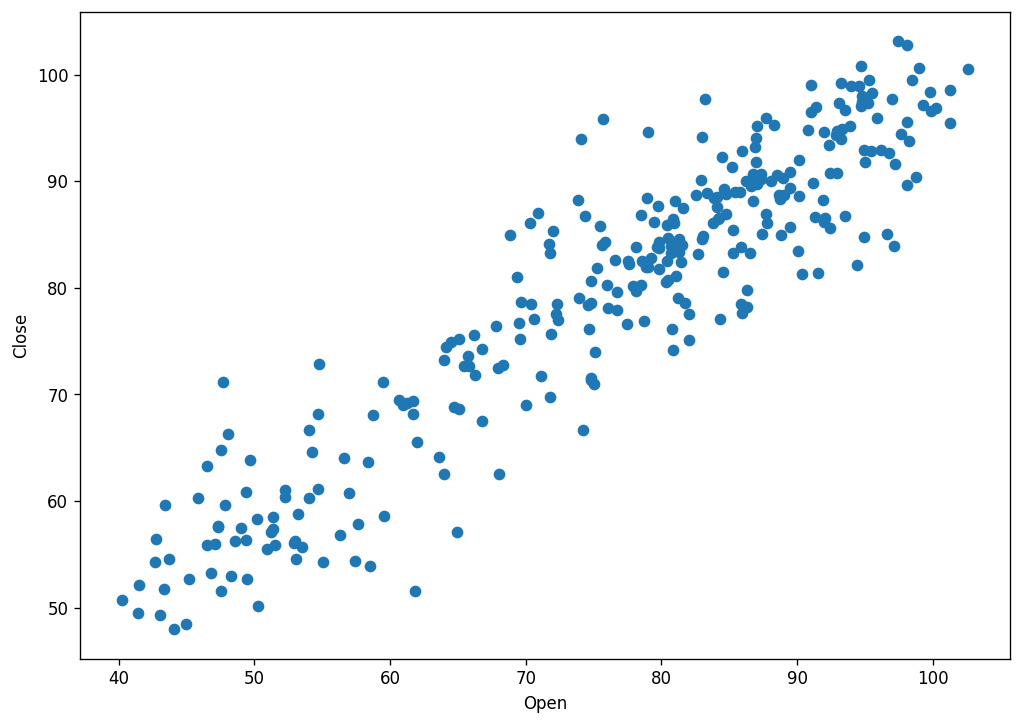

In [6]:
plt.scatter(df['Open'], df['Close'])
plt.xlabel('Open')
plt.ylabel('Close')
plt.show()

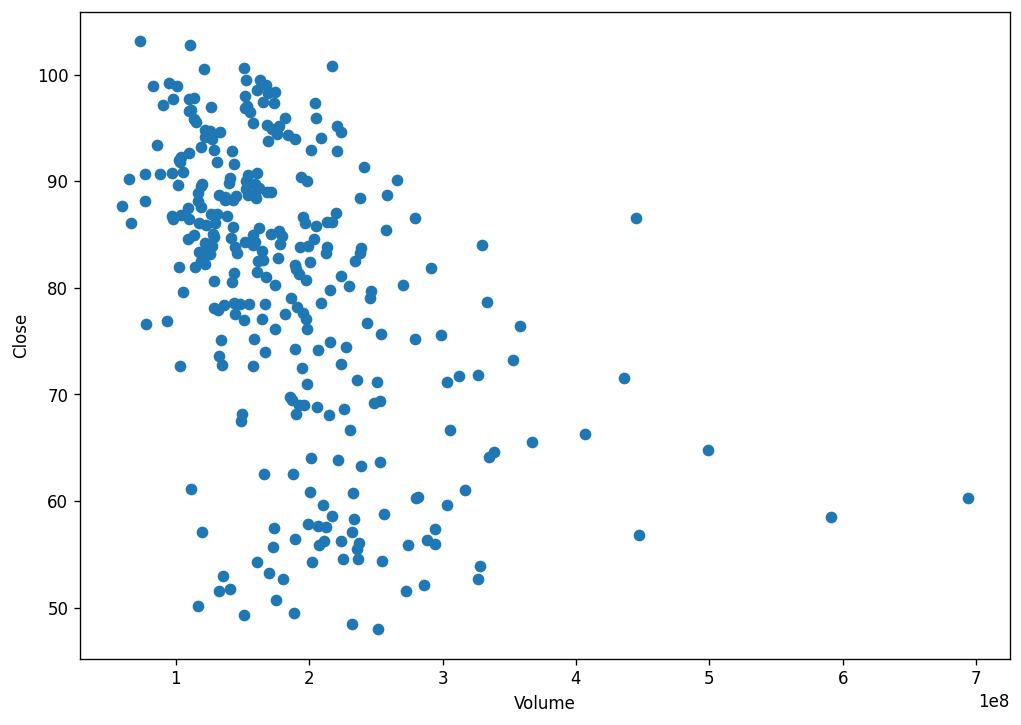

In [7]:
# create a scatter plot to visualize the relationship between two numeric columns
plt.scatter(df['Volume'], df['Close'])
plt.xlabel('Volume')
plt.ylabel('Close')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


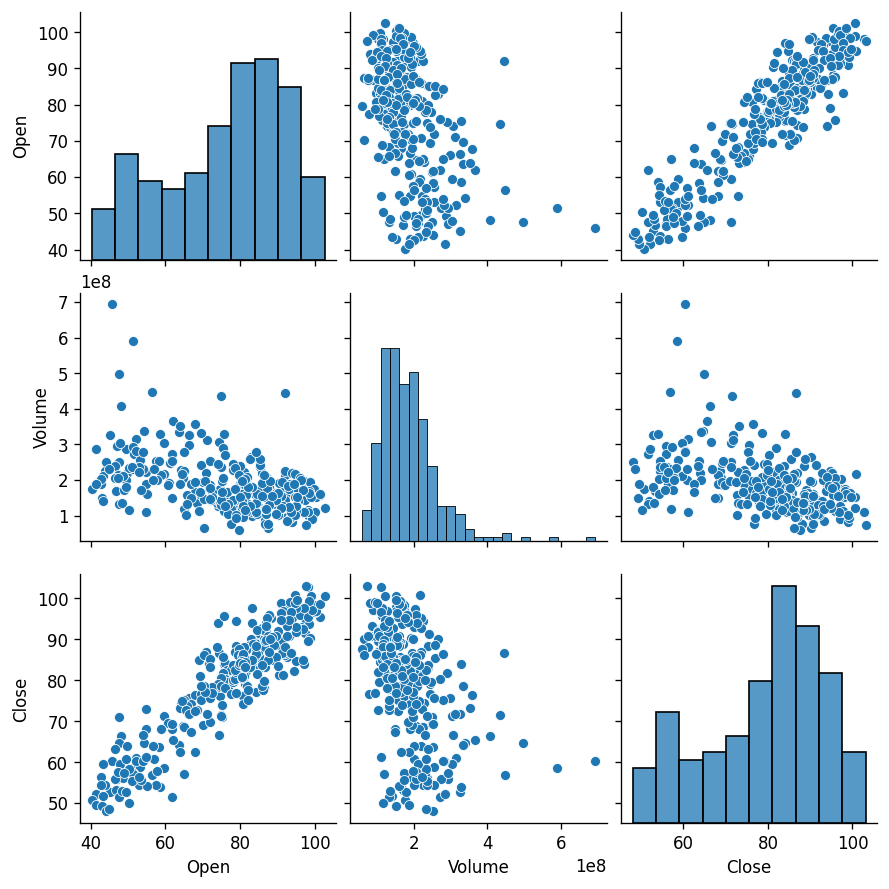

In [8]:
# create a pairplot to visualize the relationships between multiple numeric columns
sns.pairplot(df, vars=['Open','Volume', 'Close'])
plt.show()

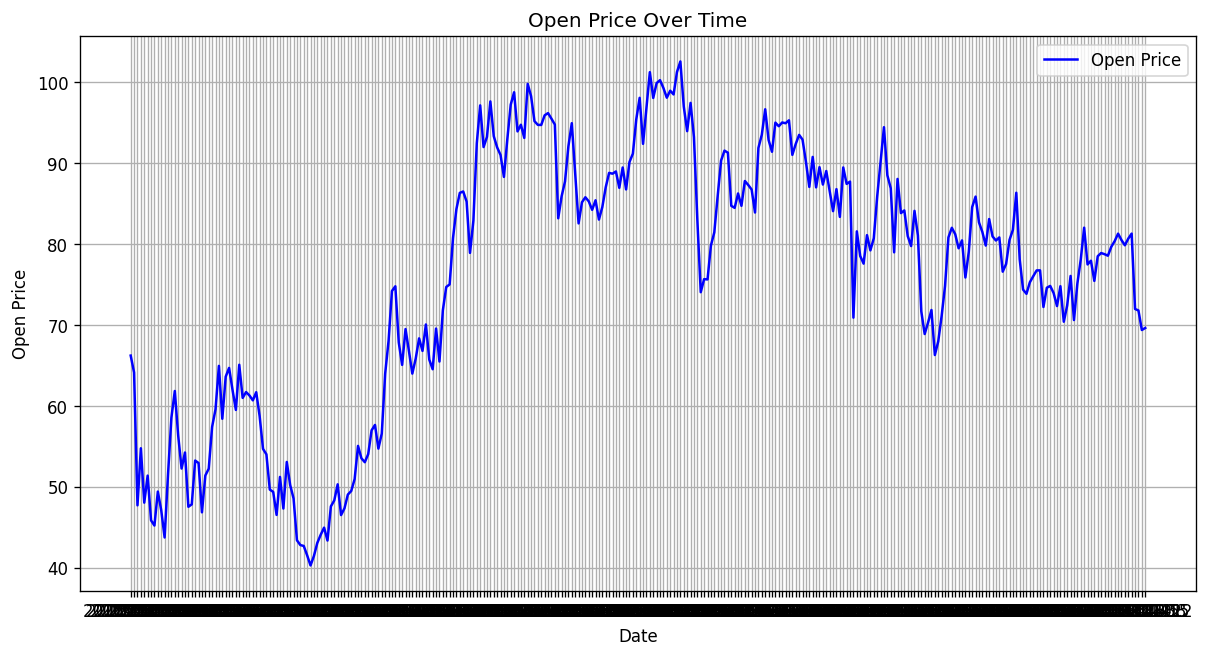

In [9]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with 'Date' and 'Open' columns
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Open'], label='Open Price', color='b')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Open Price Over Time')
plt.legend()
plt.grid(True)
plt.show()

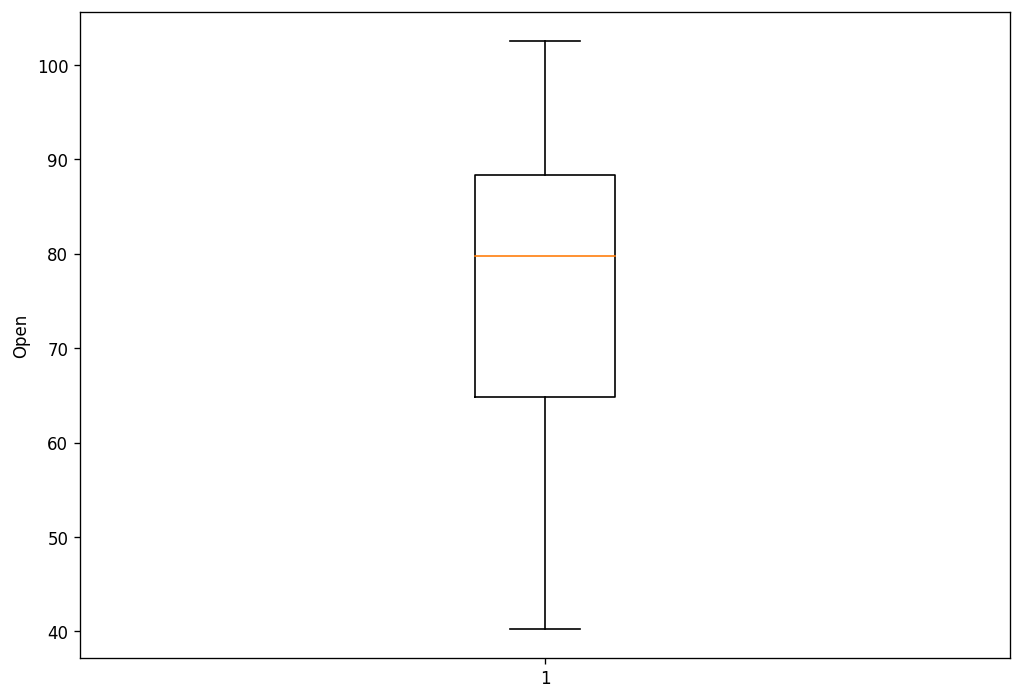

In [10]:
# create a box plot to visualize the distribution of a Open column
plt.boxplot(df['Open'])
plt.ylabel('Open')
plt.show()


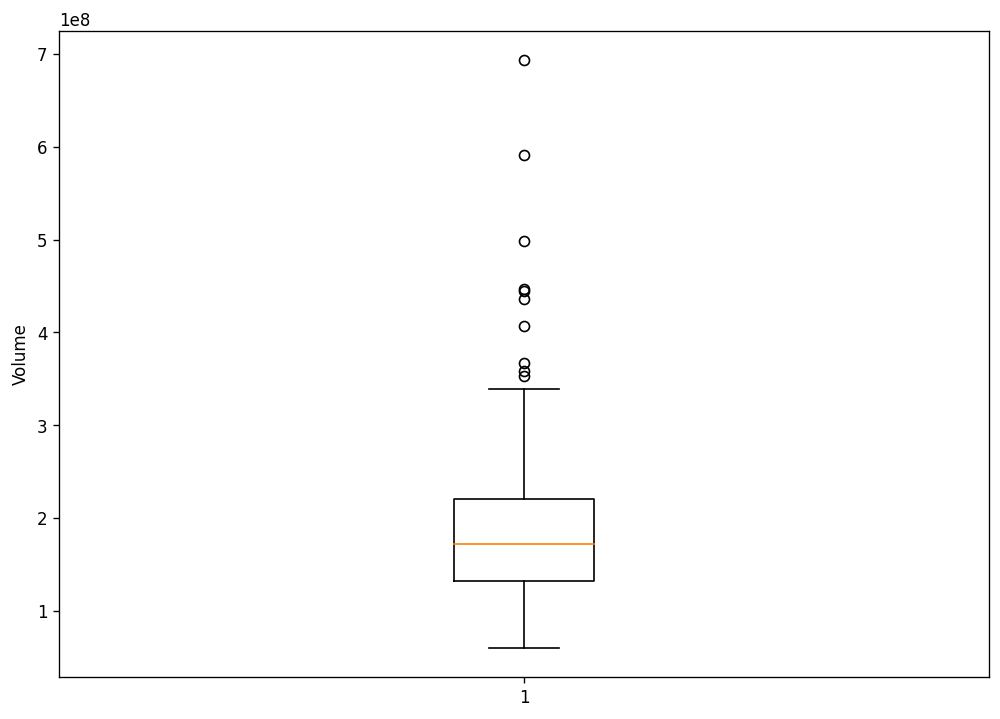

In [11]:
# create a box plot to visualize the distribution of a Volume column
plt.boxplot(df['Volume'])
plt.ylabel('Volume')
plt.show()


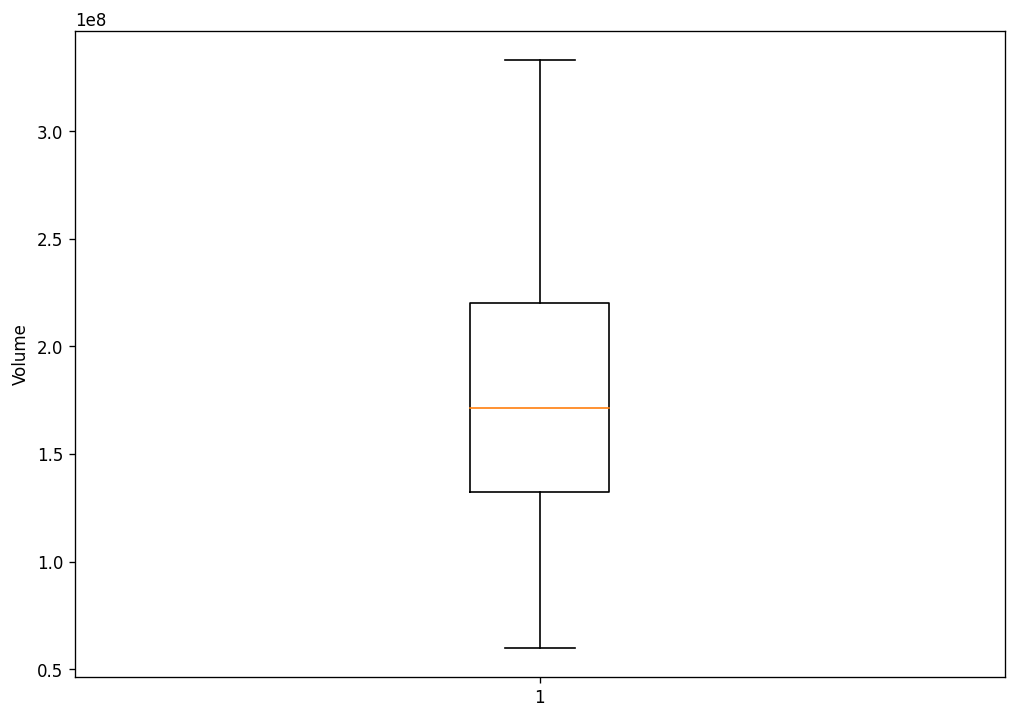

In [12]:


# Define the upper percentile value for winsorization
percentile = 0.96

# Apply winsorization to the 'Volume' column
max_value = df['Volume'].quantile(percentile)
df['Volume'] = np.where(df['Volume'] > max_value, max_value, df['Volume'])

# Create a box plot to visualize the distribution of the 'Volume' column
plt.boxplot(df['Volume'])
plt.ylabel('Volume')
plt.show()

Outliers were removed in the Model code block

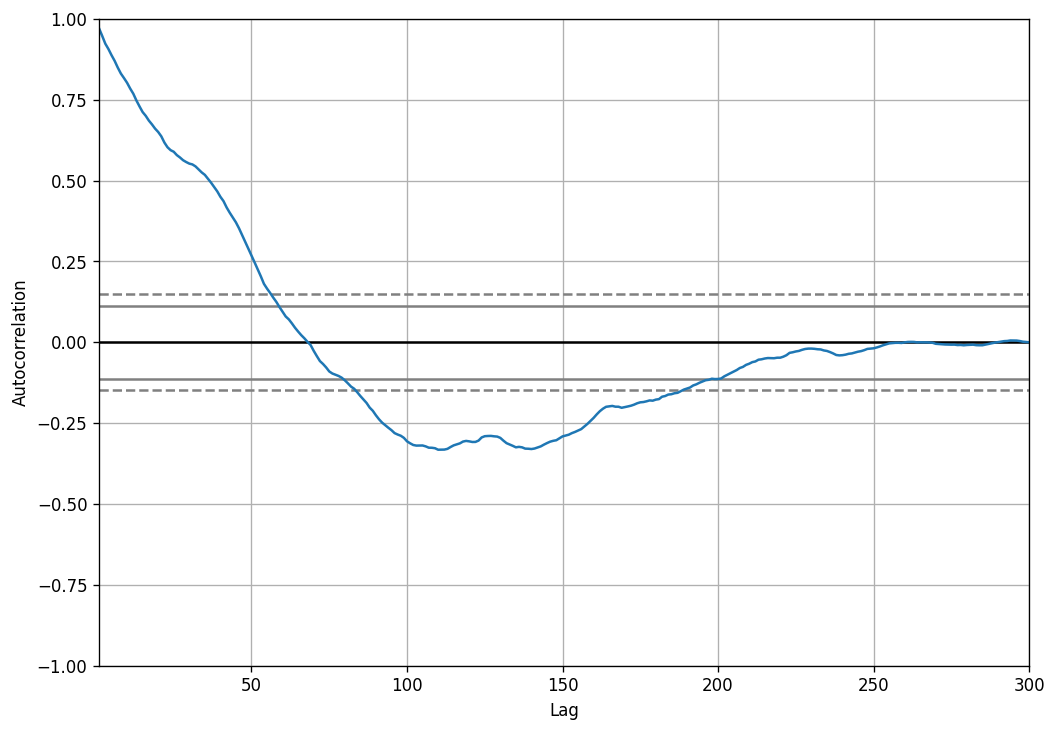

In [13]:
#create an autocorrelation plot to visualize the autocorrelation in Open column
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Open'])
plt.show()

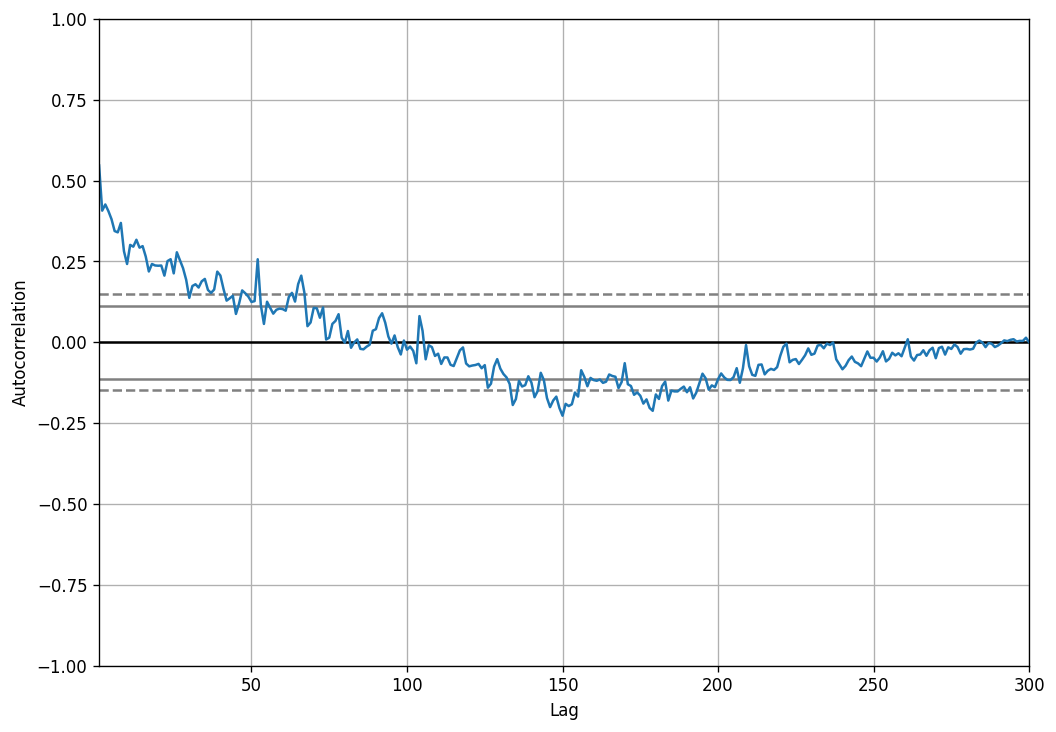

In [14]:
# create an autocorrelation plot to visualize the autocorrelation in Volume column
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Volume'])
plt.show()

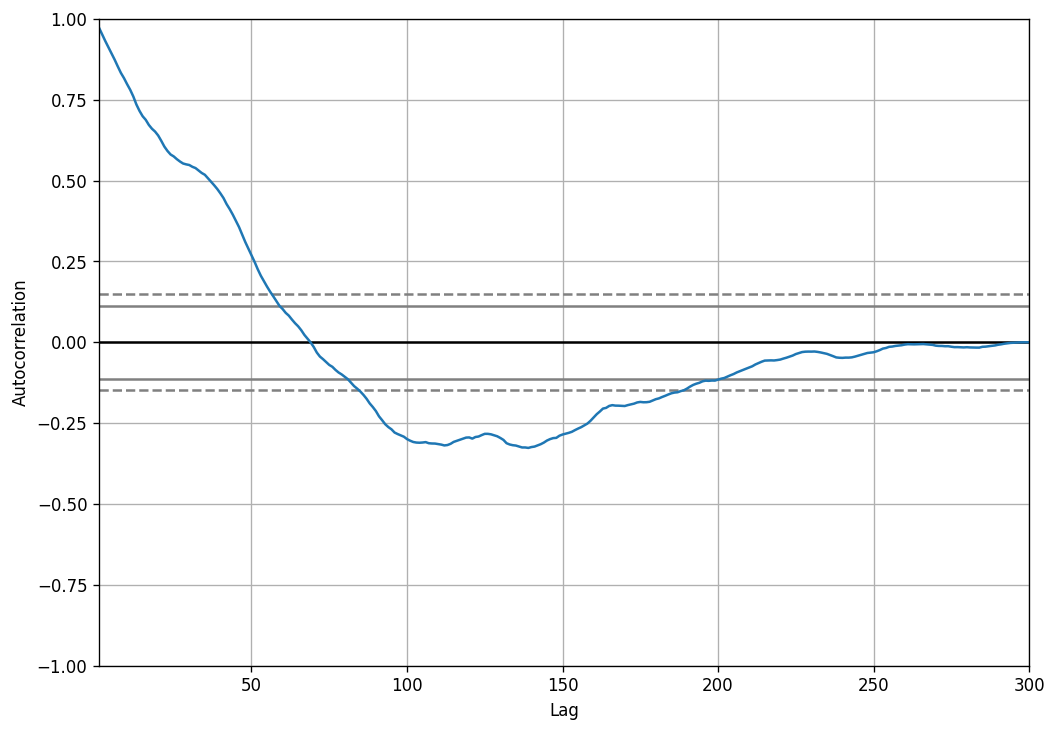

In [15]:
# create an autocorrelation plot to visualize the autocorrelation in Close column
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Close'])
plt.show()

In [16]:
# Import necessary libraries
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from scipy.stats import zscore

# Load the training and test data
train = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv", index_col=0)
test = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv", index_col=0)

# Add "Open/Volume" feature to the train data
train['Open/Volume'] = train['Open'] / train['Volume']

# Add "Open/Volume" feature to the test data
test['Open/Volume'] = test['Open'] / test['Volume']

# Calculate Z-scores for 'Volume'
train['z_score_volume'] = zscore(train['Volume'])

# Only keep rows with Z-scores less than absolute 3
train = train[train['z_score_volume'].abs() <= 3]

# Drop the 'z_score_volume' column
train.drop(columns=['z_score_volume'], inplace=True)

def TEMA(data, period):
    EMA1 = data.ewm(span=period, adjust=False).mean()
    EMA2 = EMA1.ewm(span=period, adjust=False).mean()
    EMA3 = EMA2.ewm(span=period, adjust=False).mean()
    TEMA = 3*EMA1 - 3*EMA2 + EMA3
    return TEMA
# Calculate TEMA and add it as a new feature
span = 10  # Define the span for TEMA
train['TEMA'] = TEMA(train['Close'], span)

def calculate_RSI(data, window):
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    average_gain = up.rolling(window=window).mean()
    average_loss = abs(down.rolling(window=window).mean())
    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
# Calculate RSI and add it as a new feature
window = 14  # Define the window for RSI
train['RSI'] = calculate_RSI(train['Close'], window)

# Define the calculate_MACD function
def calculate_MACD(data, short_window, long_window):
    ShortEMA = data.ewm(span=short_window, adjust=False).mean() # Short term Exponential Moving Average
    LongEMA = data.ewm(span=long_window, adjust=False).mean() # Long term Exponential Moving Average
    MACD = ShortEMA - LongEMA
    signal = MACD.ewm(span=9, adjust=False).mean()
    return MACD, signal
# Add the MACD and Signal to the train data
train['MACD'], train['Signal'] = calculate_MACD(train['Close'], 12, 26)

def calculate_bollinger_bands(data, window):
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std*2)
    lower_band = rolling_mean - (rolling_std*2)
    return upper_band, lower_band

train['Upper_Band'], train['Lower_Band'] = calculate_bollinger_bands(train['Close'], 20)

def calculate_roc(data, n):
    diff = data.diff(n)
    shift = data.shift(n)
    roc = diff / shift * 100
    return roc

n = 10  # for 10-day ROC
train['ROC'] = calculate_roc(train['Close'], n)

# Calculate EMA and add it as a new feature
span = 10  # Define the span for EMA
train['EMA'] = train['Close'].ewm(span=span, adjust=False).mean()
# Add lagged features for 'Close' with lag 1 and 4
train['Close_lag1'] = train['Close'].shift(1)
train['Close_lag4'] = train['Close'].shift(4)
# Add rolling mean and standard deviation as new features
window_size = 3  # Define the window size for rolling statistics
train['Rolling_Mean_Close'] = train['Close'].rolling(window=window_size).mean()
train['Rolling_Std_Close'] = train['Close'].rolling(window=window_size).std()

# Select input features (X) and the target variable (y_close)
X_close = train[['Open', 'Volume', 'Open/Volume']].dropna()  # For 'Close' prediction
y_close = train.loc[X_close.index, 'Close']
y_strategy = train.loc[X_close.index, 'Strategy']

# Feature Scaling: Standardize the input features for 'Close' prediction
scaler_close = StandardScaler()
X_close = scaler_close.fit_transform(X_close)

# Split the data into a training set and a validation set for 'Close' prediction
X_train_close, X_val_close, y_train_close, y_val_close = train_test_split(X_close, y_close, test_size=0.2, random_state=42)

# Model Training: Create a CatBoost model for 'Close' prediction
model_close = CatBoostRegressor(random_state=42)
model_close.fit(X_train_close, y_train_close)

# Model Inference: Make predictions on the test data for 'Close'
X_test_close = test[['Open', 'Volume', 'Open/Volume']]  # For 'Close' prediction on test data
X_test_close_scaled = scaler_close.transform(X_test_close)
test_close_predictions = model_close.predict(X_test_close_scaled)

# Calculate EMA for the test data using the predicted 'Close' values
test['Close'] = test_close_predictions
test['EMA'] = test['Close'].ewm(span=span, adjust=False).mean()
# Add TEMA to your test data as well
test['TEMA'] = TEMA(test['Close'], span)
test['RSI'] = calculate_RSI(test['Close'], window)
# Do the same for the test data
test['Close_lag1'] = test['Close'].shift(1)
test['Close_lag4'] = test['Close'].shift(4)
# Do the same for the test data
test['Rolling_Mean_Close'] = test['Close'].rolling(window=window_size).mean()
test['Rolling_Std_Close'] = test['Close'].rolling(window=window_size).std()
# Add the MACD and Signal to the test data
test['MACD'], test['Signal'] = calculate_MACD(test['Close'], 12, 26)
test['Upper_Band'], test['Lower_Band'] = calculate_bollinger_bands(test['Close'], 20)
test['ROC'] = calculate_roc(test['Close'], n)

# Select input features (X) for 'Strategy' prediction
X_strategy = train[['ROC','Upper_Band','Lower_Band','MACD','Signal','Open', 'Volume', 'Close_lag1', 'Close_lag4', 'Rolling_Std_Close', 'TEMA', 'RSI']].dropna()  # For 'Strategy' prediction

# Select the corresponding target values for 'Strategy'
y_strategy = y_strategy.loc[X_strategy.index]

# Feature Scaling: Standardize the input features for 'Strategy' prediction
scaler_strategy = StandardScaler()
X_strategy = scaler_strategy.fit_transform(X_strategy)

# Encode the 'Strategy' labels
label_encoder = LabelEncoder()
y_strategy_encoded = label_encoder.fit_transform(y_strategy)

# Split the data into a training set and a validation set for 'Strategy' prediction
X_train_strategy, X_val_strategy, y_train_strategy, y_val_strategy = train_test_split(X_strategy, y_strategy_encoded, test_size=0.2, random_state=42)

# Model Training: Create a CatBoost model for 'Strategy' prediction
model_strategy = CatBoostClassifier(random_state=42)
model_strategy.fit(X_train_strategy, y_train_strategy)

# Fill NaN values in 'SME' with the mean of the non-NaN 'SMA' values
test['EMA'].fillna(test['EMA'].mean(), inplace=True)

# Select input features (X) for 'Strategy' prediction in test data
X_test_strategy = test[['ROC','Upper_Band','Lower_Band','MACD','Signal','Open', 'Volume', 'Close_lag1', 'Close_lag4', 'Rolling_Std_Close', 'TEMA', 'RSI']]  # For 'Strategy' prediction on test data

# Feature Scaling: Standardize the input features for 'Strategy' prediction
X_test_strategy_scaled = scaler_strategy.transform(X_test_strategy)

# Model Inference: Make predictions on the test data for 'Strategy'
test_strategy_predictions = model_strategy.predict(X_test_strategy_scaled)

# Reverse label encoding to get back the original labels
test_strategy_predictions = label_encoder.inverse_transform(test_strategy_predictions)

# Create a Submission DataFrame
submission = pd.DataFrame()
submission["id"] = test.index
submission["Date"] = test["Date"]
submission["Close"] = test_close_predictions
submission["Strategy"] = test_strategy_predictions

# Save the Submission File
submission.to_csv('submission.csv', index=False)

from sklearn.metrics import accuracy_score

# Predict on the validation data
val_close_predictions = model_close.predict(X_val_close)
val_strategy_predictions = model_strategy.predict(X_val_strategy)

# Calculate accuracy for 'Strategy' prediction
accuracy = accuracy_score(y_val_strategy, val_strategy_predictions)
print(f"Accuracy: {accuracy}")


# Get feature importance for 'Close' prediction
feature_names_close = ['Open', 'Volume', 'Open/Volume']
feature_importances_close = model_close.get_feature_importance()
for score, name in sorted(zip(feature_importances_close, feature_names_close), reverse=True):
    print(f"{name}: {score}")

print("****")

# Get feature importance for 'Strategy' prediction
feature_names_strategy = ['ROC','Upper_Band','Lower_Band','MACD','Signal','Open', 'Volume', 'Close_lag1', 'Close_lag4', 'Rolling_Std_Close', 'TEMA', 'RSI']
feature_importances_strategy = model_strategy.get_feature_importance()
for score, name in sorted(zip(feature_importances_strategy, feature_names_strategy), reverse=True):
    print(f"{name}: {score}")

Learning rate set to 0.032569
0:	learn: 13.4604366	total: 54ms	remaining: 53.9s
1:	learn: 13.1437291	total: 54.7ms	remaining: 27.3s
2:	learn: 12.8576709	total: 55.3ms	remaining: 18.4s
3:	learn: 12.5586938	total: 55.9ms	remaining: 13.9s
4:	learn: 12.2803702	total: 56.4ms	remaining: 11.2s
5:	learn: 11.9967666	total: 57ms	remaining: 9.44s
6:	learn: 11.7376734	total: 57.5ms	remaining: 8.16s
7:	learn: 11.5031420	total: 58.1ms	remaining: 7.2s
8:	learn: 11.2452409	total: 58.6ms	remaining: 6.45s
9:	learn: 11.0135830	total: 59.1ms	remaining: 5.85s
10:	learn: 10.7986032	total: 59.7ms	remaining: 5.37s
11:	learn: 10.5757975	total: 60.3ms	remaining: 4.96s
12:	learn: 10.3785746	total: 60.8ms	remaining: 4.62s
13:	learn: 10.1756606	total: 61.3ms	remaining: 4.32s
14:	learn: 9.9748351	total: 61.9ms	remaining: 4.07s
15:	learn: 9.7688325	total: 62.5ms	remaining: 3.84s
16:	learn: 9.5731393	total: 63.1ms	remaining: 3.65s
17:	learn: 9.3864082	total: 63.6ms	remaining: 3.47s
18:	learn: 9.2217565	total: 64.2ms	

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
